In [1]:
%matplotlib inline

# Version 1 du modèle prédictif

On commence par importer les données dont on aura besoin

In [2]:
import pandas as pd

In [3]:
league = pd.read_csv('data\\league.csv', index_col=0)
team = pd.read_csv('data\\team.csv', index_col=0)
match = pd.read_csv('data\\match.csv', index_col=0)

On retire les colonnes suivantes : B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA car je ne sais pas à quoi elles correspondent, il n'y a aucune indication

In [4]:
match.drop(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 
            'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], 
           axis=1, inplace=True)

Dans cette version, on ne va pas s'interesser aux joeurs, on va rester au niveau de granularité supérieur, cad les équipes

In [5]:
match.drop(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 
            'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
            'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 
            'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 
            'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 
            'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 
            'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 
            'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 
            'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
            'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
            'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2',
            'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 
            'away_player_9', 'away_player_10', 'away_player_11'],
          axis=1, inplace=True)

Enfin, on ne va pas non plus encore s'interesser aux corner, possession, tirs cadrés, etc. On les supprime aussi

In [6]:
match.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession'],
           axis=1, inplace=True)

Enfin, on va rajouter les colonnes contenant le nom complet des équipes afin de les identifier plus facilement

In [7]:
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='home_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'home_team_long_name'}, inplace=True)
match = match.merge(team[['team_api_id', 'team_long_name']] , left_on='away_team_api_id', right_on='team_api_id')
match.rename(columns={'team_long_name': 'away_team_long_name'}, inplace=True)

In [8]:
match.drop(['team_api_id_y', 'team_api_id_x'], axis=1, inplace=True)

In [9]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,KRC Genk,Beerschot AC
1,483,1,1,2009/2010,5,2009-08-30 00:00:00,665353,9987,9993,1,1,KRC Genk,Beerschot AC
2,524,1,1,2010/2011,1,2010-08-01 00:00:00,838476,9987,9993,2,1,KRC Genk,Beerschot AC
3,759,1,1,2011/2012,1,2011-07-30 00:00:00,1032694,9987,9993,3,1,KRC Genk,Beerschot AC
4,1014,1,1,2012/2013,11,2012-10-20 00:00:00,1224064,9987,9993,3,0,KRC Genk,Beerschot AC


On va maintenant se limiter à la ligue 1 française dans un premier temps

In [10]:
match_ligue_1 = match[match.league_id == 4769]
num_teams = len(match_ligue_1.away_team_api_id.unique())
print(num_teams)

35


## Construction du modèle

Maintenant que les données sont propres et identifiées, on va construire le modèle pymc3. Pour cela, il faut changer les noms des équipes en indices allant de 1 au nombre total d'équipe

In [11]:
teams = match_ligue_1.home_team_long_name.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [65]:
teams

,team,i
0,AJ Auxerre,0
1,Girondins de Bordeaux,1
2,Le Havre AC,2
3,Le Mans FC,3
4,Olympique Lyonnais,4
5,AS Monaco,5
6,AS Nancy-Lorraine,6
7,Stade Rennais FC,7
8,FC Sochaux-Montbéliard,8
9,Valenciennes FC,9


In [13]:
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='home_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_home'}).drop('team', 1)
match_ligue_1 = pd.merge(match_ligue_1, teams, left_on='away_team_long_name', right_on='team', how='left')
match_ligue_1 = match_ligue_1.rename(columns = {'i': 'i_away'}).drop('team', 1)

In [14]:
match_ligue_1.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_long_name,away_team_long_name,i_home,i_away
0,4769,4769,4769,2008/2009,1,2008-08-09 00:00:00,483129,8583,9830,2,1,AJ Auxerre,FC Nantes,0,30
1,4990,4769,4769,2008/2009,3,2008-08-24 00:00:00,483150,9827,9830,2,0,Girondins de Bordeaux,FC Nantes,1,30
2,6710,4769,4769,2013/2014,13,2013-11-10 00:00:00,1468280,9827,9830,0,3,Girondins de Bordeaux,FC Nantes,1,30
3,7339,4769,4769,2014/2015,36,2015-05-09 00:00:00,1710047,9827,9830,2,1,Girondins de Bordeaux,FC Nantes,1,30
4,7750,4769,4769,2015/2016,4,2015-08-30 00:00:00,1989809,9827,9830,2,0,Girondins de Bordeaux,FC Nantes,1,30


On split notre jeu de données (60/20/20) afin de pouvoir mesurer plus tard les perfomances des différents modèles testés. NB : on fait exprès de ne pas randomiser les individus qui iront en train/CV/test. En effet, les observations sont ordonnées dans le temps, et en application réelle, on a accès uniquement au passé pour prédire le futur.

In [118]:
# On compte le nombre d'observations dont on dispose
taille_totale = len(match_ligue_1.home_team_goal.values)
# on calcule le nombre d'observations que l'on envoie en training set
train_size = int(taille_totale*0.6)
CV_size = int(taille_totale*0.8)

observed_home_goals = match_ligue_1.home_team_goal.values[:train_size]
observed_away_goals = match_ligue_1.away_team_goal.values[:train_size]

home_team = match_ligue_1.i_home.values[:train_size]
away_team = match_ligue_1.i_away.values[:train_size]

On décrit notre modélisation. On commence par spécifier les entrées et sorties de notre modélisation

In [119]:
import theano.tensor as T
import theano
import numpy as np

model_input = theano.shared(np.array([home_team, away_team]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

Puis on écrit le modèle

In [120]:
import pymc3 as pm

model = pm.Model()
with pm.Model() as model:
    # team-specific model parameters
    attaque = pm.Normal("attaque", mu=0, sd=1, shape=num_teams)
    defense = pm.Normal("defense", mu=0, sd=1, shape=num_teams)

    home_theta  = pm.math.exp(attaque[model_input[0]] - defense[model_input[1]])
    away_theta  = pm.math.exp(attaque[model_input[1]] - defense[model_input[0]])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=model_output[0])
    away_points = pm.Poisson('away_points', mu=away_theta, observed=model_output[1])

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -5,335.5: 100%|██████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.57it/s]
Finished [100%]: Average ELBO = -5,293.5
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.67it/s]


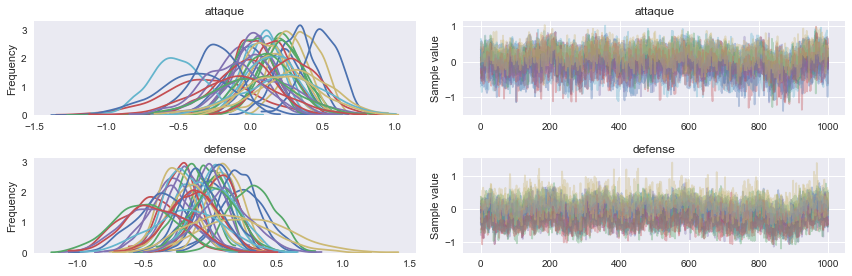

In [123]:
with model:
    trace = pm.sample(1000, n_init=10000)

    pm.traceplot(trace)

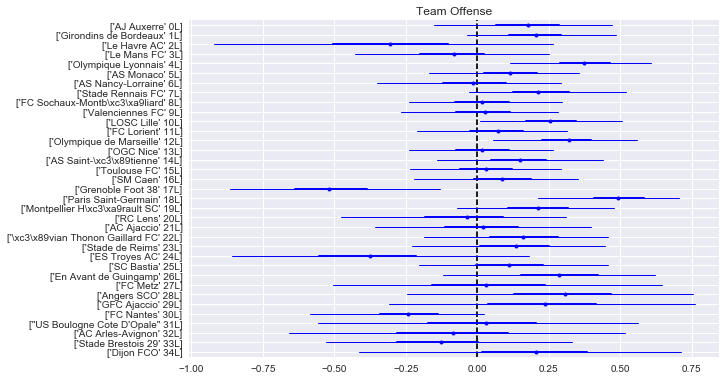

In [124]:
pm.forestplot(trace, varnames=['attaque'], ylabels=teams.values, main="Team Offense")

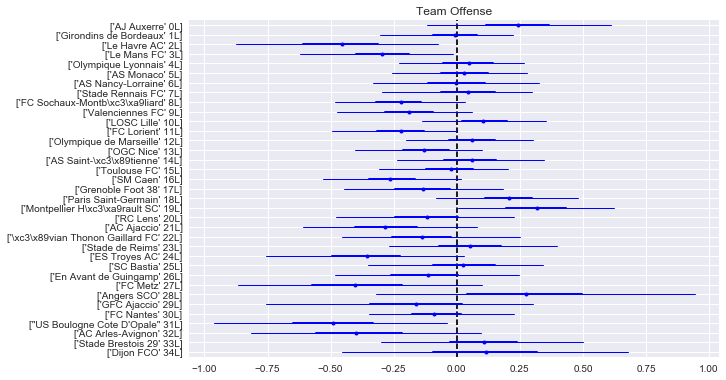

In [125]:
pm.forestplot(trace, varnames=['defense'], ylabels=teams.values, main="Team Offense")

Les résultats sont cohérents, passons à la prédiction d'un nouveau match

# Prédiction de l'issue d'un match

On cherche à prédire l'issue d'un match. Pour cela, on change les paramètres d'entrée, et on relance notre modèle : (ici : PSG contre Arles-Avignon (indice 18 vs indice 32), on s'attend à voir le PSG gagner..

In [126]:
model_input.set_value(np.array([[18],[32]]))
#model_output.set_value(np.array(Y_test))

Et on sample depuis notre modèle avec les nouvelles entrées

In [127]:
ppc = pm.sample_ppc(trace[10:], model=model, samples=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.25it/s]


On fait un peu de mise en forme des résultats afin de pouvoir les exploiter simplement

In [128]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  

prediction_score = home.merge(away, how='inner', left_index=True, right_index=True)
prediction_score.columns = ['home_points', 'away_points']

In [129]:
prediction_score.head()

,home_points,away_points
0,2,1
1,4,1
2,4,2
3,5,2
4,2,1


In [130]:
def vainqueur(row):
    if row[0] > row[1]:
        return 'H'
    elif row[0] < row[1]:
        return 'A'
    else:
        return 'N'

prediction_score['vainqueur'] = prediction_score.apply(vainqueur, axis=1)

In [131]:
prediction_score.head()

,home_points,away_points,vainqueur
0,2,1,H
1,4,1,H
2,4,2,H
3,5,2,H
4,2,1,H


In [132]:
prediction_score.vainqueur.value_counts()

H    735
N    165
A    100
Name: vainqueur, dtype: int64

On calcule les probabilités associées

In [133]:
100 * prediction_score.vainqueur.value_counts() / prediction_score.vainqueur.count()

H    73.5
N    16.5
A    10.0
Name: vainqueur, dtype: float64

On va enfin calculer le résultat le plus probable (les buts encaissés pour chacune des équipes). Une rapide visualisation nous montre que le résultat le plus probable est 2-0. Vérifions le

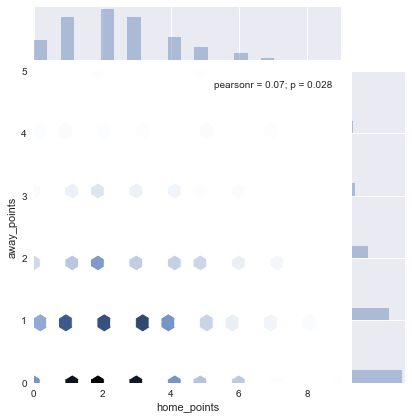

In [134]:
import seaborn
seaborn.jointplot(x='home_points',y='away_points',data=prediction_score,kind='hex')

In [135]:
prediction_score.groupby(["home_points", "away_points"]).size()

home_points  away_points
0            0               45
             1               36
             2               16
             3                2
             4                1
1            0              107
             1               71
             2               23
             3                6
             4                2
2            0              117
             1               76
             2               42
             3               11
             4                1
             5                1
3            0              104
             1               80
             2               21
             3                6
             4                1
4            0               45
             1               45
             2               20
             3                5
5            0               25
             1               18
             2               17
             3                1
             4                2
             5 

In [136]:
prediction_score.groupby(["home_points", "away_points"]).size().idxmax()

(2, 0)

In [137]:
100. * prediction_score.groupby(["home_points", "away_points"]).size().max() / prediction_score.vainqueur.count()

11.699999999999999

Conclusion, le résultat est cohérent, on s'attend à ce que le PSG l'emporte (73.5% de chances) avec un score de 2-0 (11.7 % de chances)

# Evaluation des perfomances du modèle

Maintenant que l'on a vu que notre modèle est fonctionnel (et cohérent !), nous allons dans cette dernière section évaluer notre modèle. On commence par récupérer les données de cross-validation

In [138]:
observed_home_goals = match_ligue_1.home_team_goal.values[train_size+1:CV_size]
observed_away_goals = match_ligue_1.away_team_goal.values[train_size+1:CV_size]

home_team = match_ligue_1.i_home.values[train_size+1:CV_size]
away_team = match_ligue_1.i_away.values[train_size+1:CV_size]

Et on assigne ces nouveaux individus comme entrée et sortie de notre modèle

In [139]:
model_input = theano.shared(np.array([home_team, away_team]))
model_output = theano.shared(np.array([observed_home_goals, observed_away_goals]))

In [140]:
ppc = pm.sample_ppc(trace[10:], model=model, samples=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.32it/s]


In [153]:
ppc['home_points'].shape

(1000L, 1L)

In [142]:
away = pd.DataFrame(ppc['away_points'])
home = pd.DataFrame(ppc['home_points'])  


In [143]:
away

,0
0,1
1,0
2,2
3,1
4,0
5,2
6,0
7,0
8,0
9,0


In [ ]:

prediction_score = home.merge(away, how='inner', left_index=True, right_index=True)
prediction_score.columns = ['home_points', 'away_points']